<a href="https://colab.research.google.com/github/beykyle/computational-nuclear-reactions/blob/main/441_EC_numerical_scattering_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical neutron-nucleus cross section calculations

In  this excercise, you will implement a numerical solver for the radial Schrödinger equation for an arbitrary central potential. You will then use it to calculate microscopic neutron-nucleus cross sections using a simple "optical" potential; a model for the quantum-mechanical interaction between a neutron and a nucleus. Models like this are an important ingredient for producing evaluated cross sections that are inputs to nuclear reactor calculations. The goal of this notebook is to provide a glimpse into "how the sausage is made".

In reality, we will only look at a simplified model that neglects intrinsic angular momentum (spin), and assumes a spherical nucleus. However, this will still contain the key concepts needed for a more complex treatment.


## Setting up the scattering kinematics

Our first task will be to set up our scattering system kinematics, calculating important parameters like the reduced mass. We'll show you how to do it for $^{235}$U, and then leave it up to you to implement a function to calculate the reduced mass, $\mu$, and wavenumber $k$  (definitions below) for an arbitrary system. We will stick to bombarding energies well below the mass of the neutron, so we will handle everything non-relativistically.

For two particles with projectile mass $m_p$ and target mass $m_t$, we have reduced mass:

\begin{equation}
\mu = \frac{m_p  m_t}{m_p + m_t}.
\end{equation}

In the center-of-mass (COM) frame, we have the kinetic energy in terms of the wavenumber $k$ and the reduced Plank's constant:

\begin{equation}
E_{\rm{com}} = \frac{\hbar^2 k^2 }{2 \mu}
\end{equation}

Take a minute to think about the units here. $E$ must have energy units of MeV. $k$ must have inverse length units, let's use inverse femtometers (fm$^{-1}$). If $\mu$ is in mass units of MeV$/c^2$, we can absorb the factor of $c^2$ into the numerator and use $\hbar c$ = 197.3 MeV fm.

To calculate the actual mass of the target (remember, unless we're dealing with 12C, it is not the same as the mass number), we will need the binding energy of the target. This website is convenient for getting binding energies: https://bmex.dev/beta

I get a value of $E_B = 1783.864$ MeV for $^{235}$U. The mass of a nuclide is simply the mass of all it's nueutrons and protons, less it's binding energy:

\begin{equation}
m_t = (A-Z)  m_n + Z  m_p - E_B.
\end{equation}

Finally, we will need to convert the energy of our neutrons in the lab frame to the COM frame. The com frame kinetic energy is

\begin{equation}
E_{\rm{com}} = \frac{m_t}{m_p + m_t} E_{\rm{lab}}.
\end{equation}

Of course, we would have a good approximation for light projectiles, like neutrons, if we simply set $m\approx A$ and $E_{\rm{com}} \approx  E_{\rm{lab}}$, but, we may as well just do it right.


In [ ]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# constants
HBARC = 197.326  # hbar*c in [MeV femtometers]
AMU = 931.494102  # MeV/c^2, Particle Data Group
MASS_N = 1.008665 * AMU  # MeV/c^2 PDG
MASS_P = 1.007276 * AMU  # MeV/c^2 PDG


# what are we shooting neutrons at?
# how about 235U (we are nuclear engineers after all)
A = 235  # mass number of the target
Z = 92
N = A - Z
BE = 1783.864  # Binding energy (from bmex.dev)
target_mass = Z * MASS_P + N * MASS_N - BE

# reduced mass - we will do calculations in COM frame
mu = target_mass * MASS_N / (target_mass + MASS_N)

# OK, how hard are we shooting this neutron?
# in the lab frame
energy_lab = 14.1  # MeV

# convert to COM frame
energy_com = target_mass / (MASS_N + target_mass) * energy_lab

# finally, wave number
k = np.sqrt(2 * mu * energy_com) / HBARC

We don't want to have to look up binding energies from a table, so let's use the semi-empirical mass formula to estimate them:

\begin{equation}
E_B = a_V A - a_s A^{2/3} - a_C \frac{Z(Z-1)}{A^{1/3}} - a_A \frac{(N-Z)^2}{A} + \delta{(N,Z)},
\end{equation}

where we will use
- $a_v = 15.8$
- $a_S = 18.3$
- $a_C = 0.714$
- $a_A = 23.2$,

all in MeV, and

\begin{equation}
\delta{(N,Z)} =
\begin{cases}
   + 12 \, A^{-1/2} && \text{even $N$, even $Z$} \\
   0                && \text{odd $A$} \\
   - 12 \, A^{-1/2} && \text{odd $N$, odd $Z$} \\
\end{cases}
\end{equation}

I got all of these values from [Wikipedia](https://en.wikipedia.org/wiki/Semi-empirical_mass_formula), using the least-squares fit that best reproduces measured masses.


In the following cell, implement a function that takes in a $A$, $Z$ and lab-frame bombarding energy $E_{\rm{lab}}$, and then
1. uses the semi-empirical mass formula with the given values to calculate binding energy
2. calculates the target mass
3. calculates the reduced mass
4. calculates the COM frame energy and wavenumber

<a id='problem_1'></a>

In [ ]:
# now it's your turn:
# implement a function that takes in
# A, Z, and lab-frame bombarding energy,
# and returns reduced mass, com frame kinetic energy, and k
def setup_system(A: int, Z: int,  energy_lab: float):
    """
    calculates the reduced mass, and the COM frame kinetic energy
    and wavenumber for a neutron scattering on a target nuclide
    Parameters:
        A : mass number of target
        Z : proton number of target
        energy_lab: bombarding energy in the lab frame [MeV]
    """
    N = A - Z

    delta = 0
    if N%2 == 0 and Z%2 == 0:
        delta = 12.0 / np.sqrt(A)
    elif N%2 != 0 and Z%2 != 0:
        delta = - 12.0 / np.sqrt(A)

    Eb = (
        15.8 * A
      - 18.3 * A**(2/3)
      - 0.714 * Z*(Z-1)/(A**(1/3))
      - 23.2 * (N-Z)**2/A
      + delta
    )
    target_mass = Z * MASS_P + N * MASS_N - Eb
    energy_com = target_mass / (MASS_N + target_mass) * energy_lab

    # finally, wave number
    mu = target_mass * MASS_N / (target_mass + MASS_N)

    k = np.sqrt(2 * mu * energy_com) / HBARC

    return mu, energy_com, k


In [ ]:
# if this assert fails, your implementation of setup_system is wrong
result = setup_system(235, 92, 14.1)
result = np.array(list(result))
expected = np.array([9.35549703e+02, 1.40397352e+01, 8.21379074e-01])
print(result)
print(expected)
assert( np.all(np.isclose( result, expected) ))


[9.35549703e+02 1.40397352e+01 8.21378965e-01]
[9.35549703e+02 1.40397352e+01 8.21379074e-01]


## The radial Schrödinger  equation
Now that we have our system set up, we need to figure out how to solve the Schrödinger equation given some central potential $V(r)$:

\begin{equation}
\left( \frac{-\hbar^2}{2\mu} \nabla^2 + V(r) - E_{\rm{com}} \right) \psi(\mathbf{r}).
\end{equation}

Here, everything is in the COM frame, $r$ is the distance between our target and our projectile, and $\mathbf{r}$ represents a vector in 3D space. We will require that $V(r)$ is short-range; that it goes to 0 sufficiently fast as $r \rightarrow \infty$. For our purposes, sufficiently fast will mean faster than $1/r$. This means the description below would have to be modified to handle a Coulomb interaction between charged particles; we will look at neutrons and ignore protons for now.

$E_{\rm{com}}$ is the COM frame asymptotic kinetic energy of the system, which is determined in a scattering experiment, as we saw above. We would like to solve for $\psi(\mathbf{r})$, and then use that solution to find the cross sections. Expanding $\nabla^2$ using spherical coordinates, we have this big ugly thing:

\begin{equation}
\left( \frac{-\hbar^2}{2\mu} \left[  \frac{1}{r^2} \frac{\partial}{\partial r} \left( r^2 \frac{\partial}{\partial r}\right) + \frac{1}{r^2 \sin{\theta}} \frac{\partial}{\partial \theta} \left( \sin{\theta} \frac{\partial}{\partial \theta}  \right) +  
\frac{1}{r^2 \sin^2{\theta}} \left( \frac{\partial^2}{\partial \phi^2} \right)
\right] + V(r) - E \right) \psi(\mathbf{r}).
\end{equation}

We will always work with this equation in the COM frame, so we'll drop the subscript moving forward - make sure to convert from the lab frame before doing calculations! In elastic scattering, they will also leave with the same energy. This describes the so-called "asymptotic boundary conditions" that determine the scattering problem. Remember: scattering is all about asymptotic boundary conditions.

We could come up with some fancy 3D mesh and finite element solver to tackle this problem. However, our potential $V(r)$ has spherical symmetry; it is a function of $r$, not $\mathbf{r}$. This will allow us to greatly reduce the complexity of our problem. To do this, we will employ [separation of variables](https://en.wikipedia.org/wiki/Separation_of_variables). We will use the ansatz that we can factorize $\psi(\mathbf{r})$ into functions of just $r$ and just $\theta,\phi$:

\begin{equation}
\psi(\mathbf{r}) \rightarrow \chi(r) Y(\theta, \phi).
\end{equation}

Plugging this in and re-arranging, we will find two terms, one a function of just $r$, the other of just $\theta,\phi$. We can therefore set each of these equal to a constant, which defines two separate equations for $\chi(r)$ and $Y(\theta, \phi)$:

\begin{equation}
\frac{1}{\chi(r)} \frac{d}{dr} \left( r^2 \frac{d \chi(r)}{dr} \right) - \frac{2\mu}{\hbar^2} \left(V(r) - E \right) = l(l+1),
\end{equation}

and

\begin{equation}
\frac{1}{Y(\theta,\phi)} \left[ \frac{1}{\sin{\theta}} \frac{\partial}{\partial \theta} \left( \sin{\theta} \frac{\partial Y(\theta, \phi)}{\partial \theta} + \frac{1}{\sin^2{\theta}} \frac{\partial^2 Y(\theta, \phi) }{\partial \phi^2} \right)  \right] = l (l+1),
\end{equation}

where have defined the convenient constant $l(l+1)$. For each $l$ value, we will have a solution $\chi_l(r)Y_l(\theta,\phi)$. We call these the partial waves. The general solution will be a coherent superposition of all of these partial waves:

\begin{equation}
\psi(\mathbf{r}) = \sum_l c_l \chi_l(r)Y_l(\theta,\phi).
\end{equation}

It is up to us to determine the coefficients $c_l$ for each partial wave.

### The spherical harmonics
The second equation is probably familiar, it is solved by [the spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics), $Y_l^m(\theta,\phi)$. These have solutions for $l = 0, 1, 2, \dots $, and $m = -l, -l+1, \dots, 0, \dots, l, -1, l $.

 I will state this here without proving it (although the proof is very enlightening): the value of $l$ represents the [orbital angular momentum](https://en.wikipedia.org/wiki/Angular_momentum#Angular_momentum_in_quantum_mechanics) of the projectile-target system. The value $m$ represents it's [projection](https://en.wikipedia.org/wiki/Vector_projection) onto the scattering axis. A good treatment of this is in [David Griffith's introductory quantum mechanics text](https://ia904607.us.archive.org/3/items/introduction-to-solid-state-physics-by-charles-kittel-urdukutabkhanapk.blogspot.com/Uploaded%20-%2031-03-2021/Physics%20%286%29-21-3-2021/Introduction%20to%20Quantum%20Mechanics%20by%20David%20J.%20Griffiths%20And%20Darrell%20F.%20Schroeter%20_%28urdukutabkhanapk.blogspot.com%29.pdf), section 4.1 and chapter 11.

Because our potential is central (a function of just $r$, not $\mathbf{r}$), we have azimuthal symmetry, and only the $m=0$ (azimthally symmetric) terms will show up in the expansion. These are related to the Legendre polynomials:

\begin{equation}
  Y_l^0(\theta) = \sqrt{ \frac{2l+1}{4\pi} } P_l(\cos{\theta}).
\end{equation}

Our expansion of the total wavefunction looks like this:

\begin{align}
\psi(\mathbf{r}) &= \sum_l c_l \chi_l(r)Y^0_l(\theta).\\
&= \sum_l c_l \chi_l(r)\sqrt{ \frac{2l+1}{4\pi} } P_l(\cos{\theta})
\end{align}

Let's take a look at a few of these spherical harmonics:

Y_0


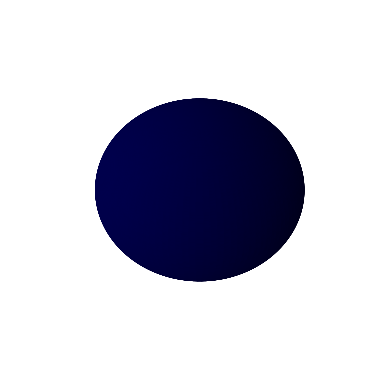

Y_1


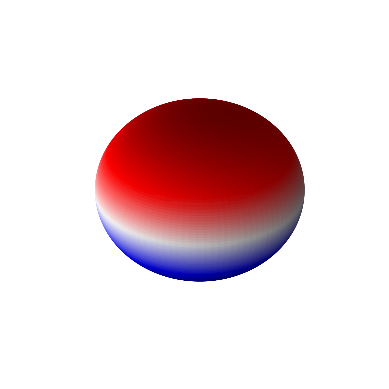

Y_2


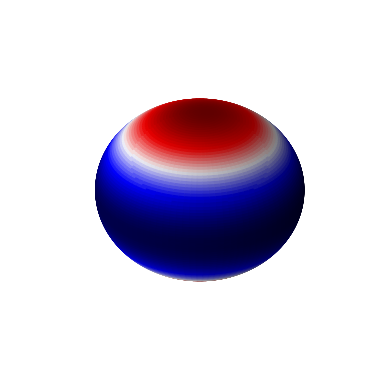

Y_3


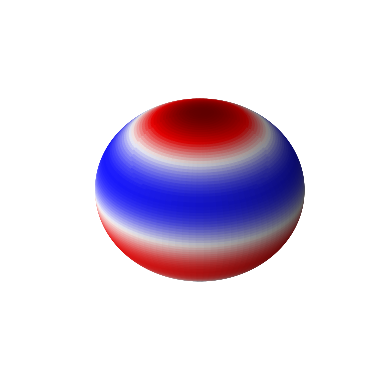

Y_4


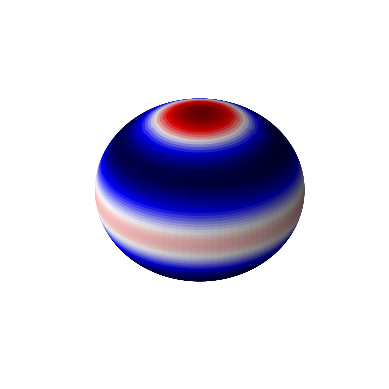

In [ ]:
# I shameless stole and adapted this from here:
# https://scipython.com/book/chapter-8-scipy/examples/visualizing-the-spherical-harmonics/
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm

phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2 * np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

# let's pick a couple (0,l) pairs to visualize
for m, l in [(0, 0), (0, 1),  (0, 2), (0, 3), (0, 4)]:
    print(f"Y_{l}")
    # Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
    fcolors = sph_harm(m, l, theta, phi).real
    fmax, fmin = fcolors.max(), fcolors.min()
    fcolors = (fcolors - fmin) / (1E-9 + fmax - fmin)

    # Set the aspect ratio to 1 so our sphere looks spherical
    fig = plt.figure(figsize=plt.figaspect(1.0))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=cm.seismic(fcolors))
    # Turn off the axis planes
    ax.set_axis_off()
    plt.show()

### The radial equation and the spherical Bessel functions

Excellent, that leaves us the task with solving the radial equation (or, really, set of equations; one for each $l$). Let's re-write it:

\begin{equation}
\left[ \frac{-\hbar^2}{2\mu} \frac{1}{r^2} \frac{d}{dr} \left(r^2 \frac{d}{dr} \right) + \frac{\hbar^2}{2\mu} \frac{l (l+1)}{r^2} + V(r) - E \right] \chi(r) = 0
\end{equation}

We can simplify this by defining $u(r) = r \chi(r)$, which leaves us with (you can derive this if you want):

\begin{equation}
\left[ \frac{\hbar^2}{2\mu}  \left( -\frac{d^2}{dr^2}  + \frac{l (l+1)}{r^2} \right) + V(r) - E \right] u(r) = 0
\end{equation}

There is no general solution for all interactions $V(r)$. Instead **we will solve this equation numerically** for a given $V(r)$.  

Notice the factor $ \frac{\hbar^2}{2\mu} \frac{l (l+1)}{r^2} $, which acts as a "centrifugal potential" - e.g. the added energy to the system due to orbital angular momentum.

Before we write our numerical solver, it's important to see how this equation behaves asymptotically. As $r\rightarrow \infty$, we must have $V(r) \rightarrow 0$, so we can write:

\begin{equation}
\left[  -\frac{d^2}{dr^2}  + \frac{l (l+1)}{r^2}  - k^2 \right] u(r) = 0,
\end{equation}

where we have used $E = \frac{\hbar^2 k^2}{2 \mu} $. This is solved for $\chi(r) = u(r)/r$ by the [spherical Bessel functions](https://en.wikipedia.org/wiki/Bessel_function#Spherical_Bessel_functions), $j_l(kr)$ and $y_l(kr)$.  These are the **free solutions to the radial equation** (free meaning $V = 0$, e.g. the target and projectile don't interact at all). We will see below that we have to impose these solutions as asymptotic boundary conditions at every $l$ to solve the full Schrödinger equation and calculate a cross section.



Note: some people use $\eta_l(kr)$ instead of $y_l(kr)$, just a heads up.

Real quick though, let's visualize our Bessel functions:

(0.0, 12.566370614359172)

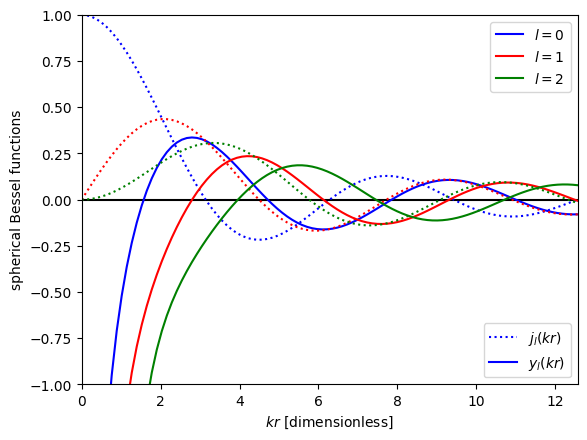

In [ ]:
from scipy.special import spherical_jn, spherical_yn
from matplotlib.lines import Line2D


nodes = 4
krgrid = np.linspace(0, nodes * np.pi, 100)
plt.plot([0, nodes * np.pi], [0, 0], "k")

for l, c in [(0, "b"), (1, "r"), (2, "g")]:
    plt.plot(krgrid, spherical_jn(l, krgrid), ":", color=c)
    plt.plot(krgrid, spherical_yn(l, krgrid), color=c)

legend_styles = [
    Line2D([0], [0], color="b", linestyle=":"),
    Line2D([0], [0], color="b"),
]

legend_colors = [
    Line2D([0], [0], color="b"),
    Line2D([0], [0], color="r"),
    Line2D([0], [0], color="g"),
]

ls = plt.legend(legend_styles, [r"$j_l(kr)$", r"$y_l(kr)$"], loc="lower right")
lc = plt.legend(legend_colors, [r"$l=0$", "$l=1$", "$l=2$"])
plt.gca().add_artist(ls)


plt.xlabel(r"$kr$ [dimensionless]")
plt.ylabel("spherical Bessel functions")
plt.ylim([-1, 1])
plt.xlim([0, nodes * np.pi])


These functions are the basis which describes scattering wavefunctions at asymptotic distances $r \rightarrow \infty$, where the target and projectile don't interact. It's important to consider the asymptotic behavior of these functions as $r\rightarrow \infty$:

\begin{align}
j_l(kr) &\rightarrow \frac{1}{kr} \sin{(kr - \pi l / 2)} \\
y_l(kr) &\rightarrow \frac{1}{kr} \cos{(kr - \pi l / 2)} \\
\end{align}

We can come up with different bases for these asymptotic functions by taking different linear combinations of the spherical Bessel functions. An important basis is that of the spherical Hankel functions, defined by:

\begin{equation}
h_l^\pm(kr) = j_l(kr) \pm i y_l(kr),
\end{equation}

which are made up of only incoming ($+$) and outgoing ($-$) spherical waves, and have asymptotic boundary conditions:

\begin{equation}
h_l^\pm(kr) \rightarrow \frac{1}{kr} (\mp i)^{(l+1)} e^{\pm i kr}.
\end{equation}


By the way, if we had a Coulomb interaction as part of $V(r)$, this is where we would have to make modifcations, by replacing the Bessel functions with [Coulomb functions](https://en.wikipedia.org/wiki/Coulomb_wave_function).

## The Numerov algorithm

Now, let's tackle the problem of solving the radial Schrödinger equation for $u(r)$ close to the origin, where $V(r) \neq 0$, and the target and projectile do feel eachother. As a reminder, for a given $l$ value, this is the equation we want to solve:

\begin{equation}
\left[ \frac{\hbar^2}{2\mu}  \left( -\frac{d^2}{dr^2}  + \frac{l (l+1)}{r^2} \right) + V(r) - E \right] u(r) = 0.
\end{equation}

We can write this as:

\begin{equation}
\left(\frac{d^2}{dr^2} + w(r) \right) u(r) = 0,
\end{equation}

where we have defined

\begin{equation}
w(r) \equiv \frac{2\mu}{\hbar^2} \left(E  - V(r) \right) - \frac{l(l+1)}{r^2}
\end{equation}

There is no general solution for most potentials $V(r)$. Instead, we will discretize $r \in \left[0,a\right]$ on a uniform grid with $N$ points; $r_0$, $r_1$, $\dots$ $r_N = a$, where we call $a$ the "channel radius". We thus have a step size of $h = a/N$.

We must pick $a$ sufficiently large such that $V(a) \approx 0$, and we can match to the asymptotic boundary conditions as $a$. We can then choose a simple finite differencing scheme to handle the second derivative, for example a [central difference](https://en.wikipedia.org/wiki/Finite_difference):

\begin{equation}
\frac{d^2}{dr^2} u(r) \approx \frac{u(r+h) + u(r-h) - 2 u(r) }{h^2}
\end{equation}

which, plugged into the radial equation, yields the recursion relation:

\begin{equation}
u(r+h) = 2u(r) - u(r-h) - h^2 w(r) u(r).
\end{equation}

This is fine, but this can be improved by including correction terms of order $h^2$ in the differencing:

\begin{equation}
\frac{u(r+h) + u(r-h) - 2 u(r) }{h^2} - \frac{h^2}{12} \frac{d^4}{r^4}u(r) +w(r) u(r) = 0,
\end{equation}

By multiplying from the left by $1+ \frac{h^2}{12} \frac{d^2}{dr^2}$, and then dropping all $\mathcal{O}(h^4)$ terms, we get the equation:

\begin{equation}
\frac{u(r+h) + u(r-h) - 2 u(r) }{h^2} + w(r)u(r) + \frac{h^2}{12}\frac{d^2}{dr^2} \left( u(r) w(r) \right).
\end{equation}

We can simply use another central difference approximation for the second derivative of $\left( u(r) w(r) \right)$ in the last term, as the prefactor of $h^2/12$ will render our correction terms $\mathcal{O}(h^4)$. Plugging this in and re-arranging yields the recursion relation:

\begin{equation}
u(r+h) = \frac{2 u(r) - u(r-h) - \frac{h^2}{12} \left( 10 \, w(r) u(r) + w(r-h)u(r-h)  \right)}{1 + \frac{h^2}{12} w(r+h)}.
\end{equation}

This is the Numerov method, also referred to as the Fox-Goodwin method.

***This is the numerical scheme you will implement below.***

We will solve from 0 out, so we need initial conditions as $r\rightarrow 0$; we will use $u(0) = 0$ and $u(1)=1$. This choice enforces that the wavefunction doesn't blow up at 0, and sets an over all phase for the wavefunction. However, overall phase and normalization don't matter for scattering problems, what we are really interested in is the phase difference between the free and scattered wavefunction, as we will see.

One gotcha here is that the centrifugal term in $w(r)$ diverges at the origin. To get around this, we will solve the system starting at $h$, not 0. In general, wavefunctions can be complex, so we have to make sure our solver can handle that (luckily `numpy` can handle all of this for us).

<a id='problem_2'></a>

In [ ]:
def numerov_solver(v, h, a, l, mu, E):
    """
    Solves the radial Schrodinger eqn
    Parameters:
        v : a callable function that takes in a radius r in fm,
            and returns the interaction potential in MeV
        h : radial step size in fm
        a : channel radius in fm
        l : orbital angular momentum quantum number
        mu : reduced mass in MeV/c^2
        E  : COM frame kinetic energy in MeV
    """

    N = int(round(a / h)) - 1 # number of steps
    rgrid = np.linspace(h,a,N)
    u = np.zeros_like(rgrid, dtype=complex)  # array for solution

    # set complex initial conditions
    u[0] = 1 + 1j
    u[1] = 1 + 1j

    # set up w and v on radial grid
    vgrid = v(rgrid)
    wgrid = 2*mu/HBARC**2 * (E - vgrid) - l*(l+1)/rgrid**2

    # define convenient constant
    hr = h**2 / 12

    # forward Euler solve for r in  [h , a]
    for i in range(1, N - 1):
        num = (
            2 * u[i] - u[i - 1]
            - hr * (10 * wgrid[i] * u[i] + wgrid[i - 1] * u[i - 1])
        )
        den = 1 + hr * wgrid[i + 1]
        u[i + 1] = num / den

    return u

Now that you've implemented the solver, let's test it! We will use a Yukawa interaction potential to do so:

\begin{equation}
V(r) = -V_0 \frac{\exp(-\frac{r}{R})}{r},
\end{equation}

We will choose the constant $R$; the range of the potential, to be 5 fm, and $V_0$, the strength, to be 50 MeV. Let's define and visualize this potential, and use [`scipy.integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) as an out-of-the box solver to benchmark our implementation of Numerov.

In [ ]:
def yukawa(r):
    return -50 * np.exp(-r / 5) / r

In [ ]:
# out of the box scipy solver (uses Runge-Kutta backend)
from scipy.integrate import solve_ivp

def scipy_solver(v, h, a, l, mu, E):
    N = int(round(a / h))  # number of steps
    rgrid = np.linspace(h,a,N-1)

    # set complex initial conditions
    ics = [
        1 + 1j,  # phi
        0 + 0j  # phi prime
    ]

    sol = solve_ivp(
        lambda r, phi: np.array(
        [
            phi[1],
            2 * mu / HBARC**2 * (v(r) - E) * phi[0] \
            + l * (l + 1) / r**2 * phi[0],
        ]),
        [h,a],
        ics,
        dense_output=True,
    )
    return sol.sol(rgrid)[0]


Ok, we are ready to test our Numerov solver. Let's set up a simple problem of scattering on our Yukawa potential:

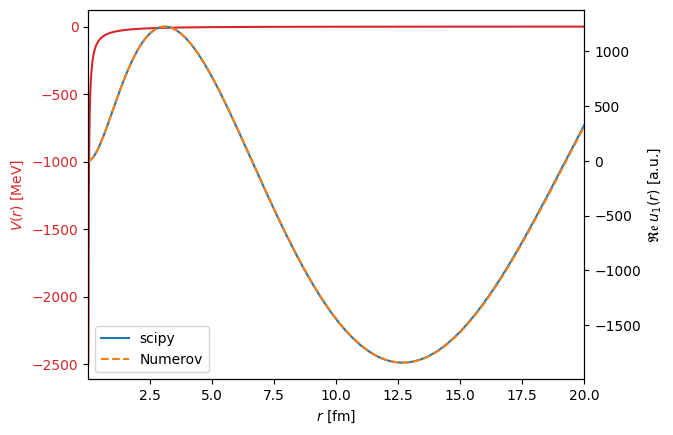

In [ ]:
# set up the Yukawa scattering problem
a = 20.0 # channel radius [fm]
N = 1000 # number of radial grid points
h = a/float(N) # step size

rgrid = np.linspace(h,a,N-1) # full radial grid, exclusive of 0

l = 1 # p-wave scattering - change this to any integer

# set up the scattering system
elab = 1.2 # MeV
mu, ecom, k = setup_system(235, 92, elab )

# benchmark scipy solver
benchmark = scipy_solver(yukawa, h, a, l, mu, ecom )

# our Numerov solver
numerov = numerov_solver(yukawa, h, a, l, mu, ecom )

# plot the two solutions, along with the potential
fig, ax1 = plt.subplots()
ax1.plot(rgrid, yukawa(rgrid), label=r"Yukawa potential $V(r)$", color='tab:red')
ax1.set_xlim([h, 20])
ax1.set_xlabel(r"$r$ [fm]")
ax1.set_ylabel(r"$V(r)$ [MeV]", color="tab:red")
ax1.tick_params(axis='y', labelcolor="tab:red")

ax2 = ax1.twinx()
norm = np.max(np.real(benchmark)) / np.max(np.real(numerov))
ax2.plot(rgrid, np.real(benchmark),  label="scipy")
ax2.plot(rgrid, np.real(numerov) * norm, "--", label="Numerov")
ax2.set_ylabel(r"$\mathfrak{Re} \; u_{%d}(r)$ [a.u.]"%l)

plt.legend(loc="lower left")
plt.show()

If the `Numerov` wavefunction does not agree with the benchmark `scipy` wavefunction, you did not implement the Numerov algorithm correctly!
Make sure to try a few different values of $l$ and $E^{\rm{lab}}$ to ensure your solver works.

## The optical model

The Yukawa potential we used above can be good for some cases, but the professionals in nucleon-nucleus reactions use something called optical model potentials. Optical model potentials are a class of models for the interaction between a nucleon and a nucleus. They are typically phenomenological (tuned to experiment), and attempt to describe the energy-averaged behavior (e.g. they treat resonances only on average). They are important tools for evaluating nuclear cross sections, especially in the fast neutron region, and for regions of the chart of isotopes that are difficult to access experimentally.


For the interested, one of the most commonly used optical potentials was created in [2003 by Koning and Delaroche](https://www.sciencedirect.com/science/article/pii/S0375947402013210?casa_token=MyOMbEfEwkwAAAAA:jcD30qI-5JObIVcGCDXiFxbiStTFOTlDow3ncy7dG4qjYPqftLnhzglHA64DJO_GzMsInWxoLg). We will use a much simpler version here.

These potentials often use the so-called Woods-Saxon functional forms to model the shape of the potential as a function of the projectile-target separation $r$:

\begin{equation}
V(r;V_0,R,a) = -V_0 \frac{1}{1 + \exp{\frac{r- R}{a}}}.
\end{equation}

This looks like a finite spherical well with depth $V$ and radius $R$, except the edge is "smoothed" by a diffuseness parameter $a$. It has long been known that the nuclear surface region is important in nuclear reactions. Many optical potentials therefore also include a surface peaked term parameterized as the derivative of a Woods-Saxon function. This is called the surface term, whereas the other term is called the volume term.

The surface term is especially important at low energy, when an incident nucleon cannot penetrate deeply into nucleus, and instead interacts primarily with the valence nucleon's wavefunctions. For our purposes, our optical potential, $V^{\rm{opt}}$, will be the sum of a volume term and a surface term. Let's take a look at these potential shapes:

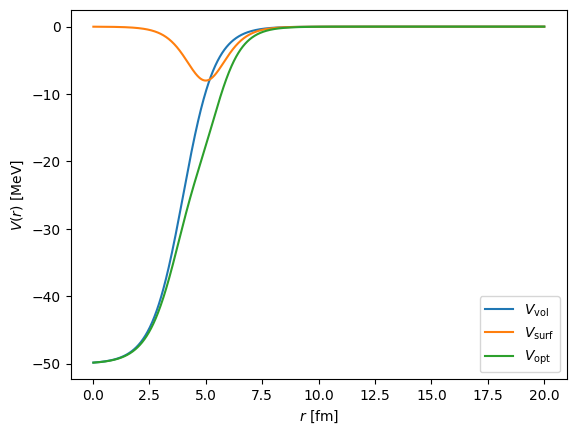

In [ ]:
def woods_saxon(r, params):
    """ volume term """
    V0, R, a = params
    return V0 / (1 + np.exp((r - R) / a))


def woods_saxon_deriv(r, params):
    """ surface term """
    V0, R, a = params
    return 4 * V0 * a / a * np.exp((r - R) / a) / (1 + np.exp((r - R) / a)) ** 2

def optical_potential(r, params):
    """ volume + surface """
    params_vol, params_surf = params
    return woods_saxon(r, params_vol) + woods_saxon_deriv(r, params_surf)


# some realistic parameters
volume_params = (-50, 4, 0.7)
surface_params = (-8, 5, 0.6)
params = (volume_params, surface_params)

# calculate values of the potentials
surf = woods_saxon_deriv(rgrid, surface_params)
vol = woods_saxon(rgrid, volume_params)
optical = optical_potential(rgrid, params)

# plot them
plt.plot(rgrid, vol, label=r"$V_{\rm{vol}}$")
plt.plot(rgrid, surf, label=r"$V_{\rm{surf}}$")
plt.plot(rgrid, optical, label=r"$V_{\rm{opt}}$ ")

plt.xlabel(r"$r$ [fm]")
plt.ylabel(r"$V(r)$ [MeV]")
plt.legend()
plt.show()

In general, we might allow the depth parameters, $V_{\rm{vol}}$ and $V_{\rm{surf}}$, to be complex. The imaginary part models the absorption of the incident neutron (more precisely, the removal from the elastic channel - so in this case "absorbtion" means all reactions except elastic scattering). We will discuss this in more detail later on.

In total, then, we have 8 parameters in our model; each term having a real and imaginary depth, a radius, and a diffuseness parameter. The dynamics of scattering on these potentials will be entirely dictated by these parameters, along with the reduced mass and energy of the system.

Let's use our solver look at some wavefunctions for scattering on our optical potential:

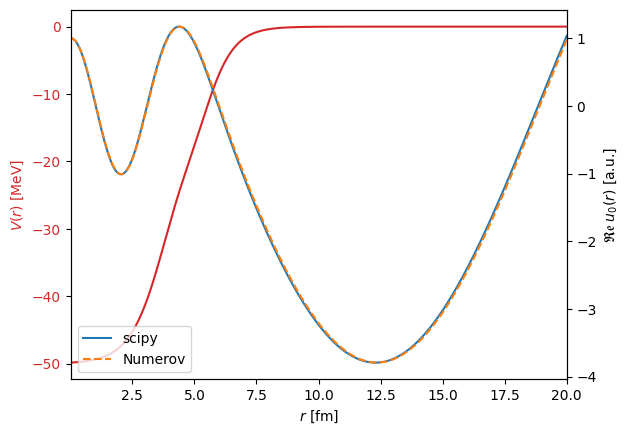

In [ ]:
# use same rgrid, mu, ecom, etc. as before
l = 0  # s-wave

# benchmark solver
benchmark = scipy_solver(lambda r: optical_potential(r, params), h, a, l, mu, ecom)

# our solver
numerov = numerov_solver(lambda r: optical_potential(r, params), h, a, l, mu, ecom)

# plotting
fig, ax1 = plt.subplots()
ax1.plot(
    rgrid,
    optical_potential(rgrid, params),
    label=r"Yukawa potential $V(r)$",
    color="tab:red",
)
ax1.set_xlim([h, 20])
ax1.set_xlabel(r"$r$ [fm]")
ax1.set_ylabel(r"$V(r)$ [MeV]", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
norm = np.max(np.real(benchmark)) / np.max(np.real(numerov))
ax2.plot(rgrid, np.real(benchmark), label="scipy")
ax2.plot(rgrid, np.real(numerov) * norm, "--", label="Numerov")
ax2.set_ylabel(r"$\mathfrak{Re} \; u_{%d}(r)$ [a.u.]" % l)

plt.legend(loc="lower left")
plt.show()

Finally, we have a realistic interaction, and a robust numerical scheme for calculating the resulting wavefunction. But how do we get a cross section from the wavefunction?

First, we have to ask:

## What is a cross section?

This section will get a little technical, and is not strictly necessary. We will use the time-independent formulation of scattering, which describes particles in terms of plane waves. This is much more convenient than the time-dependent formulation in terms of scattering wave-packets, which are really how we describe a moving particle in quantum mechanics. It turns out that these are strictly equivalent, but we will not derive that here. This should conceptually make sense, however; as we can build a wavepacket by superimposing the right distribution of plane waves.

A differential cross section $\frac{d \sigma}{d \Omega}$  is related the probability that, per unit incident probability amplitude on our target, there is a given probability amplitude flowing away asymptotically far from the target in direction $d\Omega$ about $\mathbf{\Omega}$.  To understand how to get this quantity from a wavefunction, we have to discuss **conservation of probability** in quantum mechanics.

In QM, the probability of measuring a system in a state $ |\alpha \rangle$<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) is

\begin{align}
\langle \alpha | \alpha \rangle
    &= \int_{\mathbb{R}^3} d\mathbf{r} \langle \alpha | r \rangle \langle r | \alpha \rangle \\
    &= \int_{\mathbb{R}^3} d\mathbf{r} |\psi_{\alpha}(r)|^2 \\
\end{align}

We have the probabilty of the wavefunction in our state $|\alpha \rangle$ to be in some $d\mathbf{r}$ abour $\mathbf{r}$:

\begin{equation}
\rho(\mathbf{r} ) d\mathbf{r} = |\psi_{\alpha}(r)|^2 d\mathbf{r}
\end{equation}

Thus, the complex square $|\psi|^2 = \psi^\dagger \psi$ (here $\dagger$ denotes a complex conjugate) of the wavefunction satisfies our idea of a [*probability density*](https://en.wikipedia.org/wiki/Probability_density_function), which we call $\rho(\mathbf{r})$.



This probability density has a continuity equation that is required by [unitary time evolution](https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)#Schr%C3%B6dinger_equation). In other words, the total wavefunction normalization $\int_{\mathcal{R}^3} d\mathbf{r} |\psi_{\alpha}(r)|^2$<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2) must remain unity at all times, we don't create or destroy particles. This is stated as:

\begin{equation}
\frac{\partial}{\partial t} \rho(\mathbf{r}) + \nabla \cdot \mathbf{j}(\mathbf{r}) = 0,
\end{equation}

where we have defined the probability current $\mathbf{j}(\mathbf{r})$ (don't confuse this $j$ with the Bessel functions). The [time-dependent Schrödinger equation](https://en.wikipedia.org/wiki/Schr%C3%B6dinger_equation#Time-dependent_equation) tells us how to take time-derivatives of wavefunctions, in particular; using the Hamiltonian, $\hat{H}$, as a time-evolution operator:

\begin{equation}
i \hbar \frac{\partial}{\partial t} =  \hat{H} = \frac{\hbar^2}{2\mu} \nabla^2 + V(\mathbf{r}).
\end{equation}

This is a foundational statement in physics, that symmetry in time is equivalent to conservation of energy. We can apply this to the time derivatives in our continuity equation to yield:


\begin{align}
- \nabla \cdot \mathbf{j}(\mathbf{r})
&= \frac{\partial}{\partial t} \psi^\dagger \psi \\
&= \psi^\dagger \frac{\partial}{\partial t} \psi + \psi \frac{\partial}{\partial t} \psi^\dagger \\
&= \frac{-i}{\hbar} \left( \psi^\dagger \hat{H} \psi + \psi \hat{H} \psi^\dagger \right) \\
\end{align}


As long as our potential is Hermitian ($V = V^\dagger$), which we require to give us unitarity, the potential terms cancel, and we have:

\begin{align}
- \nabla \cdot \mathbf{j}(\mathbf{r})
&= \frac{-i \hbar}{2\mu} \left(
    \psi^\dagger \nabla^2 \psi + \psi \nabla^2 \psi^\dagger
    \right)\\
&= -\nabla \cdot \frac{i \hbar}{2\mu} \left(\psi^\dagger \nabla \psi + \psi \nabla \psi^\dagger\right) \\
\mathbf{j}(\mathbf{r})  &= \frac{i \hbar}{2\mu} \left(
    \psi^\dagger \nabla \psi  -  \psi \nabla \psi^\dagger \right) \\
&= \frac{\hbar}{\mu} \mathfrak{Im} \psi^\dagger \nabla \psi
\end{align}

Consider the current of particles out of a differential area element $d \mathbf{A} = \hat{\mathbf{r}} \, r^2 d\Omega$:

\begin{align}
\mathbf{j}(\mathbf{r}) \cdot d\mathbf{A} &= r^2 j_r (r) d\Omega \\
 &= \frac{\hbar}{\mu}
\left(
  \mathfrak{Im} \psi^\dagger  \frac{d}{dr}  \psi
\right)  r^2 d\Omega.
 \end{align}

As we discussed above, the outgoing, scattered component of $\psi$ looks asymptotically like the spherical Hankel function $h_l^+(kr)$:

\begin{equation}
h_l^+(kr) \rightarrow \frac{1}{kr} (-i)^{(l+1)} e^{+ i kr}.
\end{equation}

To be fully general, the wavefunction is a superposition over all values of $l$, but each term in the sum has the $l$-independent factor $e^{+ i kr}/r$. We can factor out this term, and write the sum over $l$, without loss of generality, as some arbitrary function of solid angle $f(\Omega)$, which is determined by the dynamics of scattering:

\begin{equation}
\psi^+ \rightarrow f(\Omega) \frac{e^{ikr}}{r}.
\end{equation}

Substituting into our formula for the probability current through $d\mathbf{A}$, we have, as $r \rightarrow \infty$, the scattereed current through $d\mathbf{A}$:

\begin{equation}
 \mathbf{j}_s(\mathbf{r}) \cdot d\mathbf{A} \rightarrow \frac{\hbar k}{\mu}  \frac{|f(\Omega)|^2}{r^2} r^2 d\Omega
\end{equation}

To determine a differential cross section, we have to normalize this quantity by the incident current, using a form for the incident flux: $\psi_{\rm{inc}} = e^{-ikr}$. This leads to

\begin{equation}
j_{\rm{inc}} = \frac{\hbar k}{\mu} = v,
\end{equation}

where we have defined the velocity $v$. You may be troubled that this does not have thr right units, but the differential cross section is a ratio of outgoing to incoming current, so the current units cancel. Really though, we should use a normalization of inverse volume to get the right units (where we would implicitly take the limit as the volume goes to $\infty$, but this is just bookeeping -- as we mentioned, it will cancel in the cross section). We can finally write:

\begin{align}
   &d\sigma \equiv \frac{\mathbf{j}_s(\mathbf{r}) \cdot d\mathbf{A}}{j_{\rm{inc}}} = |f(\Omega)|^2 d\Omega \\
   &\frac{d\sigma}{d\Omega} = |f(\Omega)|^2
\end{align}

Thus the problem of determining a cross section is then equivalent to determining this function $f(\Omega)$ (up to an overall phase), which we will do by expanding in terms of the spherical harmonics.




#### Footnotes:

<a name="cite_note-1"></a>1.[](#cite_ref-1) We use the abstract notation $\alpha$ to emphasize that this is true not just in the coordinate basis $\mathbf{r}$, but in any other basis as well (e.g. momentum, angular momentum, energy, etc.). From here on out though, we will stay in the coordinate basis, and talk about wavefunctions $\psi(\mathbf{r})$.


<a name="cite_note-2"></a>2. [](#cite_ref-2) I'm glossing over some big mathematical details here. In particular, a free particle has a wavefunction that can be expressed in linear combinations of $j_l(kr)$ and $y_l(kr)$, which are not normalizable in the sense written. They are normalizable in another sense, but you have to take a functional analysis course to find out how.


## Calculating a cross section: partial wave expansion

We call the expansion in terms of the spherical harmonics the **partial wave expansion**. We've already hinted how this might look: we've decomposed the Schrödinger equation into spherical harmonics, each $l$ value having a corresponding radial equation. We now have the ability to solve this equation numerically, up to some channel radius $a$. What we will now do is match each of these numerically-solved radial equations to their respective asymptotic boundary conditions, and show that the algebraic solution to each of these boundary condition equations determines a term in our expansion of $f(\Omega)$ over $l$.

### The $\mathcal{S}$ and $\mathcal{T}$ matrices

Let's once again consider the radial equation:

\begin{equation}
\left[ \frac{\hbar^2}{2\mu}  \left( -\frac{d^2}{dr^2}  + \frac{l (l+1)}{r^2} \right) + V(r) - E \right] u(r) = 0.
\end{equation}

The solver we implemented can give us $u_l(r) = r \chi_l(r)$ for $r \in \left[ 0, a\right]$, for an arbitrary $V(r)$. How do we find the asymptotic boundary conditions for each partial wave so we can do this matching?

Let's consider an instance of scattering with COM-frame wavenumber $k$. This can be beam hitting a target, or it can simply be a neutron traveling in a straight line in a reactor until it hits a nucleus in the moderator or fuel. In either case, we will orient our coordinate system so that our incident particle will be a plane wave along the $z$-axis.

\begin{equation}
    \psi_{\rm{inc}} = e^{ikz}.
\end{equation}

We will write the asymptotic scattered wave as a sum of outgoing Hankel functions. The total outgoing wave will include the scattered wave, as well as the portion of the incident wave which travels through the target without ineracting. Thus our total wavefunction, as $r\rightarrow \infty$, will be:


\begin{align}
   \psi &\equiv \psi_{\rm{inc}} + \psi_{\rm{scatter}} \\
   &= e^{ikz} + \sum_{l} c_l h_l^+(kr) Y^0_l(\theta),
\end{align}

were $c_l$ represents our unknowns we would like to solve for.

We can use the handy [Rayleigh expansion](https://en.wikipedia.org/wiki/Plane-wave_expansion) to write our incident plane wave also as a series of $l$ terms:

\begin{equation}
e^{ikz} = \sum_l^\infty (2l+1) i^l P_l(\cos{\theta}) j_l(kr).
\end{equation}

Plugging this in, and writing $Y^0_l$ in the scattered wavefunction in terms of the Legendre polynomials, we have:

\begin{align}
   \psi  &= \sum_{l}
   \left[ (2l+1) i^l  j_l(kr)
   +  \sqrt{\frac{2l+1}{4\pi}}  c_l h_l^+(kr)\right] P_l(\cos{\theta})
\end{align}

We will define a new expansion factor $t_l$ such that $c_l =t_l i^l \sqrt{4\pi (2l+1)}$, for convenience, and factor out the rest of the common factors between the incident and scattered wave terms:

\begin{align}
   \psi  &= \sum_{l}
   \left[  j_l(kr) +  t_l h_l^+(kr)\right]
   (2l+1) i^l  P_l(\cos{\theta})
\end{align}

Now $t_l$ has a clear meaning - for an **incoming plane wave** with unit amplitude in the $l$th partial wave, there will be a scattered, **outgoing spherical-wave** with amplitude $t_l$ in partial wave $l$. We call these coefficients elements of the $\mathcal{T}$-matrix.

What we mean by this, is that we are free to choose any asymptotic wavefunction basis we want - spherical Bessel, Hankel, whatever. Each choice of bases is related by a [linear transformation](https://en.wikipedia.org/wiki/Linear_map#Matrices), and, as such, we can describe our scattering problem by some other matrix, which is related to the $\mathcal{T}$-matrix by a linear transformation.

Let's see an example of this. Instead of using the basis consisting of an incident plane wave and an outgoing spherical wave; $j_l(kr), h_l^+(kr)$,  let's convert to a basis consisting of just incoming and outgoing spherical waves $h_l^-(kr), h_l^+(kr)$.

For each partial wave, we have a superposition $j_l(kr) +  t_l h_l^+(kr)$. If instead, we had a superposition $h^-_l(kr) +  s_l h_l^+(kr)$, for some unkown $s_l$, can we write this $s_l$ in terms of $t_l$? The answer is yes, by plugging in the definition of the Hankel functions, which we remind ourselves of here:

\begin{equation}
h_l^\pm(kr) = j_l(kr) \pm i y_l(kr).
\end{equation}

We can see (try it yourself), that setting $2i t_l = s_l  - 1$ is the solution to

\begin{equation}
j_l(kr) +  t_l h_l^+(kr) = h_l^{-}(kr) +  s_l h_l^+(kr).
\end{equation}


We call $s_l$ the $\mathcal{S}$-matrix, and it also has a clear physical meaning: for an **incoming spherical wave** with unit amplitude in partial wave $l$, there is, asymptotically, a scattered, **outgoing spherical wave** in partial wave $l$ with amplitude $s_l$.

As we shall see, the $\mathcal{S}$, or the $\mathcal{T}$-matrix, (or any other linear transformation of them), fully determines the differential scattering cross section.


### Calculating the cross section

It is most convenient to calculate the cross section in the $\mathcal{T}$-matrix basis. Our partial wave expansion is

\begin{align}
   \psi  &= \sum_{l}
   \left[  j_l(kr) +  t_l h_l^+(kr)\right]
   (2l+1) i^l  P_l(\cos{\theta}).
\end{align}

We can compare the asymptotic form of this expansion to the asymptotic form of the scattered wave given an incident plane wave of unit amplitude; $\psi^+ \rightarrow f(\Omega) \frac{e^{ikr}}{r}$, and determine $f(\Omega)$.

Plugging in the asymptotic forms of the Bessel and Hankel functions into our expansion, we have:

\begin{align}
   \psi  &\rightarrow
   \sum_{l}
   \left[  j_l(kr) +  t_l \frac{e^{ikr}}{kr} \right]
   (2l+1) i^l  P_l(\cos{\theta}).
\end{align}


By inspection, we can see:

\begin{align}
f(\theta)
&= \frac{1}{k} \sum_l (2l+1) t_l P_l (\cos{\theta}) \\
&= \frac{1}{2ik} \sum_l (2l+1) (s_l - 1) P_l (\cos{\theta}) ,
\end{align}

and we finally have

\begin{equation}
\frac{d \sigma}{d\theta} = \left| \frac{1}{k} \sum_l (2l+1) t_l P_l (\cos{\theta}) \right|^2,
\end{equation}

and
\begin{align}
\sigma &= \frac{1}{2\pi}  \int_{2\pi} d\theta  \;  \left| \frac{1}{k} \sum_l (2l+1) t_l P_l (\cos{\theta}) \right|^2 \\
&= \frac{4\pi}{k^2} \sum_l (2l+1) | t_l |^2,
\end{align}

where we have used the orthogonality of the Legendre polynomials to get the second line. We could just as easily write these in terms of the $\mathcal{S}$-matrix elements. This is useful because we can write the $\mathcal{S}$-matrix in terms of a phase shift applied to the wavefunction.

By the way - we call all these objects matrices because, in more complex problems, there is coupling between channels, and we have, in general, $s_{ll'} \neq 0$. In our simple problem, all off-diagonal elements are 0, and we use $s_l$ to denote the diagonal elements of the $\mathcal{S}$-matrix. This is why our partial wave expansion is so nice - it defines a linear system of **un**-coupled equations.

### Matching the internal and asymptotic wavefunction to get $\mathcal{T}$-matrix elements

The final missing step to calculate the cross section is to numerically solve the wavefunction in the internal region for partial wave $l$ out to a channel radius $a$ such that $V(r \geq a) \approx 0$, and then match to the asymptotic expansion.

This is most conveniently done in the $\mathcal{S}$-matrix basis. Consider the quantity

\begin{equation}
R_l \equiv  \frac{1}{a} \frac{\chi_l(a)}{\chi_l'(a)} =  \frac{1}{a} \frac{u_l(a)}{u_l'(a)}
\end{equation}

Of course, this is also a fancily-named thing called the $\mathcal{R}$-matrix. This is something we can calculate using our numerical solver. However, at $r=a$, this should also match with the asymptotic partial wave:

\begin{equation}
R_l = \frac{1}{a} \frac{ h_l^-(ka) - s_l h_l^+(ka) }
                       { h'^-_l(ka) - s_l  h'^+_l(ka)}.
\end{equation}

We can algebraically solve this for the $s_l$:

\begin{equation}
s_l = \frac{ h_l^-(ka) - a R_l h_l'^-(ka) }
           { h_l^+(ka) - a R_l h_l'^+(ka) }.
\end{equation}

So by calculating $R_l$ numerically, we can obtain $s_l$ for each partial wave. For short-range potentials, $s_l \rightarrow 1$ as $l \rightarrow \infty$, and we only need then first few $s_l$ values to calculate a cross section.

Our final task will be to implement a cross section calculator using our solver. We want a function that takes in a set of optical potential parameters, and spits out a differential cross section and a total cross section. This is a bit tricky to get right, so I've done it for you, using the Numerov solver you implemented.

In [ ]:
from scipy.special import spherical_jn, spherical_yn
from scipy.misc import derivative
from scipy.interpolate import interp1d

# Define the asymptotic wavefunctions

def F(rho, ell):
    '''
    Bessel function of the first kind.
    '''
    return rho*spherical_jn(ell, rho)


def Y(rho, ell):
    '''
    Bessel function of the second kind.
    '''
    return -rho*spherical_yn(ell, rho)


def H_plus(rho, ell):
    '''
    Hankel function of the first kind.
    '''
    return Y(rho, ell) + 1j*F(rho, ell)


def H_minus(rho, ell):
    '''
    Hankel function of the second kind.
    '''
    return Y(rho, ell) - 1j*F(rho, ell)


def H_plus_prime(rho, ell, dx=1e-6):
    '''
    Derivative of the Hankel function (first kind) with respect to rho.
    '''
    return derivative(lambda z: H_plus(z, ell), rho, dx=dx)


def H_minus_prime(rho, ell, dx=1e-6):
    '''
    Derivative of the Hankel function (second kind) with respect to rho.
    '''
    return derivative(lambda z: H_minus(z, ell), rho, dx=dx)

In [ ]:
from scipy.special import eval_legendre as P

# we will calculate l only up to LMAX
LMAX = 20
# hard code the radial grid size
GRIDSIZE = 5000
# default grid on which to evaluate the differential cross section
DEFAULT_THETA_GRID = np.linspace(0, np.pi, 100)


def calculate_xs(
    Ecom: float,
    mu: float,
    a: float,
    params: tuple,
    theta_grid: np.array = DEFAULT_THETA_GRID,
):
    """Calculates the differential, total and reaction cross
    sections for neutron scattering on a target with interaction
    modeled as an optical potential.
    Parameters:
        Ecom : COM-frame kinetic energy [MeV]
        mu : reduced mass [MeV/c^2]
        a : channel radius [fm]
        params : optical potential params, must contain two tuples
        one for the volume term params and one for the surface term.
        Each of these tuples should have 3 floats (V,R,a),
        where:
            - V is the depth [MeV]
            - R the width [fm]
            - a the diffuseness [fm]
        of the corresponding term.
        theta_grid (optional) : the angular grid on which to evaluate
        the differential cross section [radians]
    """
    h = a / float(GRIDSIZE)
    rgrid = np.linspace(h, a, GRIDSIZE - 1)
    k = np.sqrt(2 * mu * Ecom) / HBARC
    Vopt = lambda r: optical_potential(r, params)

    ftheta = np.zeros_like(theta_grid, dtype=complex)

    sigt = 0
    sigrxn = 0
    sigel = 0

    # solve system for each partial wave
    for l in range(LMAX + 1):
        # solve the radial Shrodinger eqn out to r=a
        u = numerov_solver(Vopt, h, a, l, mu, Ecom)

        # calculate the derivative at a, and the R-matrix
        u = interp1d(rgrid, u, bounds_error=False)
        Rl = 1 / a * (u(a - h) / derivative(u, a - h, 1.0e-6))

        # calculate the S-matrix element
        sl = (H_minus(k * a, l) - a * Rl * H_minus_prime(k * a, l)) / (
            H_plus(k * a, l) - a * Rl * H_plus_prime(k * a, l)
        )
        # and the T-matrix element
        tl = (sl - 1) / 2j
        ftheta += (2 * l + 1) / k * tl * P(l, np.cos(theta_grid))

        # and finally, add the relevant term to the running
        # sums for each xs
        sigt += (1 - np.real(sl)) * (2 * l + 1)
        sigrxn += (1 - np.real(sl * np.conj(sl))) * (2 * l + 1)
        sigel += np.real((1.0 - sl) * np.conj(1.0 - sl)) * (2 * l + 1)

    # don't forget the factors of k^-2
    sigt *= 2 * np.pi / k**2
    sigrxn *= np.pi / k**2
    sigel *= np.pi / k**2

    # convert from fm^2 to mb
    return 10 * ftheta * np.conj(ftheta), 10 * sigt, 10 * sigrxn, 10 * sigel

Energy | total xs [mb]
_______|______________
0.1    | 3.203e+04
5      | 7.176e+03
20     | 2.241e+03
100    | 3.321e+03


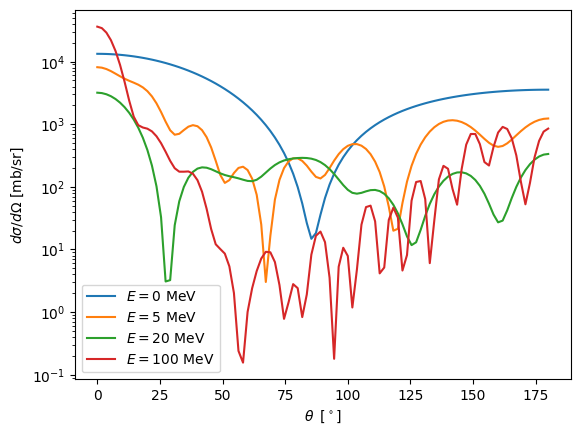

In [ ]:
# nice, let's test it out!
print("Energy | total xs [mb]")
print("_______|______________")

for ecom in [0.1, 5, 20, 100]:
    dxds, sigt, _, _ = calculate_xs(ecom, mu, a, params)
    print("{:<6} | {:1.3e}".format(ecom, sigt))
    plt.plot(
        180 * DEFAULT_THETA_GRID / np.pi, dxds, label=r"$E = {:1.0f}$ MeV".format(ecom)
    )

plt.legend()
plt.yscale("log")
plt.xlabel(r"$\theta \;\;\left[^\circ\right]$")
plt.ylabel(r"$d\sigma / d \Omega $ [mb/sr]")
plt.show()

Well isn't that nifty! Notice that at low energies, the differential cross section looks more isotropic than at high energies, where it becomes more forward-peaked. Also notice these dips - we call them diffraction peaks. These are important observables that we can measure in elastic scattering experiments, and are very sensitive to the range $R$ of the Woods-Saxon potential.

Notice that our function returns some new things we haven't discusses yet: a reaction cross section, and an elastic cross section.

If you print them out in the previous cell next to the total cross section, you'll notice the reaction cross sections are all 0, and $\sigma_{\rm{el}} = \sigma_{t}$. Why is this? What does this reaction thing mean and how do we make it non-zero? Let's briefly explore this.



### A quick dip into non-Hermitian interactions

We mentioned above that we may allow our depth terms to be complex. This violates the conservation of probability argument we made above when deriving our cross section, as $V \neq V^\dagger$. A physicist would say that the Hamiltonian is no longer [Hermitian](https://en.wikipedia.org/wiki/Hermitian_operator), and the corresponding time evolution is [non-unitary](https://en.wikipedia.org/wiki/Unitary_operator). But in regular people speak, this just means that we allow particles to be created or destroyed - we are now modeling an [open quantum system](https://en.wikipedia.org/wiki/Open_quantum_system)!

You may have noticed that the simple description we've derived only allows for elastic scattering - the total and elastic cross sections are the same. The system can never leave the elastic channel. By simply adding negative complex terms to the potential, we can model our projectile leaving the elastic channel to form a compound nucleus with the target, without making any major modifications to our formalism. Of course, this only treats inelastic processes in an average sense - to account for specific, discrete resonances we need to use a more complicated formalism we won't talk about here. If you're curious, physicists have derived what these imaginary terms should look like, using a formalism called [Feshbach-Fano partitioning](https://en.wikipedia.org/wiki/Feshbach%E2%80%93Fano_partitioning).

In the definition of probability current, the original term will remain the same, giving rise to the same differential and angle-integrated cross section. However, we will also get a cross section for transition to non-elastic channels. Adding the non-elastic (we call this the reaction cross section) and elastic cross sections together gives the new total cross section, which is clearly no longer equal to just the elastic cross section. In terms of currents, we will get an term extra arising due to the non-Hermitian nature of our interaction $V$, which we will call $j_{\rm{rxn}}$:

\begin{align}
  \frac{d}{dr} j_{\rm{rxn}} &=
  \frac{-i}{\hbar} \left( \psi^\dagger V \psi - \psi V^\dagger \psi^\dagger \right) \\
  &=\frac{2}{\hbar}  \mathfrak{Im} \psi^\dagger V \psi \\
   j_{\rm{rxn}} &=\frac{2}{\hbar}  \int_0^\infty dr \, \mathfrak{Im} \psi^\dagger V \psi \\
\end{align}

Decomposing this integration into partial waves leads to:

\begin{align}
  j_{\rm{rxn}}  &= \sum_l (2l+1) \frac{2 i^l}{\hbar k r} P_l(\cos{\theta})
  \left[ \int_{0}^a \chi_l^\dagger(r) \, \mathfrak{Im} V \, \chi_l(r) dr \right] \\
\end{align}

 We can determine $l$-wave constribution by applying integration by parts twice. We can write the boundary terms at $r=a$  in terms of $s_l$.


\begin{equation}
  \frac{8\mu}{\hbar^2 k} \left[ \int_{0}^a \chi_l^\dagger(r) \, \mathfrak{Im} V \, \chi_l(r) dr \right] =  1 - |s_l|^2 \equiv T_l,
\end{equation}

which defines the transmisson coefficient, $T_l$. Conceptually, because the $\mathcal{S}$-matrix is no longer unitary, $|s_l|^2$ now may be less than 1. $T_l$ therefore tells us *how much* non-unitarity this interaction enacts on partial wave $l$; in other words, what fraction of the probability amplitude is absorbed. The reaction cross section is

\begin{equation}
\sigma_{\rm{rxn}} = \frac{\pi}{k^2} \sum_l (2l+1) T_l
\end{equation}

In summary, the reaction cross section is the cross section for removal from the elastic channel, and we have for our new total cross section:

\begin{align}
\sigma_t &= \sigma_{\rm{rxn}} +  \sigma_{\rm{el}} \\
&= \frac{\pi}{k^2}\sum_l (2l+1)  (1 - |s_l|^2  + |s_l-1|^2) \\
&= \frac{2\pi}{k^2}\sum_l (2l+1)  (1 -\mathfrak{Re} s_l)
\end{align}

Let's explore the total and reaction cross sections as a function of energy for a complex potential.

In [ ]:
# %%timeit

# add imaginary depth terms
volume_params = (
    -50 - 2j,
    4,
    0.7,
)  # large real and small negative imaginary volume term
surface_params = (0 - 18j, 5, 0.6)  # purely imaginary negative surface term
params = (volume_params, surface_params)

# create a grid over energy and intialize arrays for
# energy dependent cross sections
grid_size = 400
egrid = np.logspace(-2, 2, grid_size)
sigt = np.zeros(grid_size)
sigrxn = np.zeros(grid_size)
sigel = np.zeros(grid_size)

# run the solver at each energy
for i, ecom in enumerate(egrid):
    _, t, rxn, el = calculate_xs(ecom, mu, a, params)
    sigt[i] = t
    sigrxn[i] = rxn
    sigel[i] = el

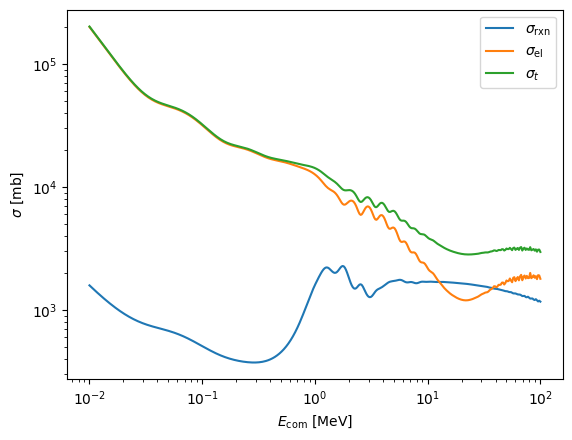

In [ ]:
# plot the cross sections
plt.loglog(egrid, sigrxn, label=r"$\sigma_{\rm{rxn}}$")
plt.loglog(egrid, sigel, label=r"$\sigma_{\rm{el}}$")
plt.loglog(egrid, sigt, label=r"$\sigma_t$")

plt.ylabel(r"$\sigma$ [mb]")
plt.xlabel(r"$E_{\rm{com}}$ [MeV]")
plt.legend()
plt.show()

Recall the features we expect to see; a $1/k$ dependence at low energy, and the reaction and elastic cross sections adding up to the total. What do we not see? Well for one, resolved resonances are conspicously absent. The optical model can give us energy-averaged cross sections only, where the interval over which we average is much larger than the resonance widths.

## Exploring how cross sections vary across the nuclear chart

There have been many attempts to come up with optical models for which the parameters, $(V,R,a)$, and others, are themselves functions of $A$ and $Z$, so that a single function can explain cross sections all across the chart of isotopes. We will consider an exceptionally simple such form, where the radius goes as $A^{1/3}$ - consistent with the liquid drop model. Recall that nuclear matter is incompressible; it has a saturation density. The (positive) Woods-Saxon shape roughly mimics the density of nucleons; this rough shape is universal across the chart due to nucleons always packing themselves into the same saturation density.

Let's come up with a rough parameterization that reflects this behavior:

\begin{align}
R &= R_0 + R_A A^{1/3}
\end{align}

I will handpick some parameters that are similar to the ones given in [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0375947402013210). We will use for the volume term:

- $R_v = 1.3 A^{1/3} - 0.4 $
- $a_V = 0.68 $.

For the surface term:

- $R_s = 1.3 A^{1/3} - 0.016 $
- $a_s = 0.54 $.

All these are in fm. There is evidence that the depth terms have an isovector dependence; that is, they depend on the asymmetry between neutrons and protons. We see a similar concept in the the asymmetry dependence of the semi-empirical mass formula. We will choose a form like so:

\begin{equation}
V = V_0 + V_{\alpha}\left( \frac{N-Z}{N+Z} \right)
\end{equation}

I will again make up some realistic parameters: We will use for the volume term:

- $ \mathfrak{\;Re} V_v = 59.3 - 21.0 \left( \frac{N-Z}{N+Z} \right)$
- $ \mathfrak{\;Im} V_V = 12.2 $

For the surface term:

- $ \mathfrak{\;Re} V_s = 0$
- $ \mathfrak{\;Im} V_s = 16.0 -16.0 \left( \frac{N-Z}{N+Z} \right) $.

All of these are in MeV. Typically, these parameterizations have an energy dependence as well, but we will ignore this for simplicity.

Your task now is to put all these tools together, and implement a function that takes in $A$, $Z$, and returns the `tuple` of parameters that we pass into `optical_potential`. Then, define an energy grid, choose a few different isotopes, and compare the energy dependent cross sections between them in our model. Do these predictions seem realistic? What are the trends in $A$, $Z$ and $(N-Z)/(N+Z)$?

It is also worthwhile to compare the differential scattering cross section our model predicts for a few different isotopes, at a given energy. In particular, notice how the diffraction pattern changes as a function of $A$.

<a id='problem_3'></a>

In [ ]:
def calculate_params(A, Z):
    """
    calculates the volume and surface term depth, radius and
    diffuseness for an optical potential given A and Z, and
    returns it as a tuple
    """
    N = A - Z
    alpha = (N - Z) / A

    Vv = (59.3 - 21.0 * alpha) + 1j * 12.2
    Vs = 1j * (16.0 - 16.0 * alpha)

    Rv = 1.3 * A ** (1 / 3) - 0.4
    Rs = 1.3 * A ** (1 / 3) - 0.016

    av = 0.68
    asurf = 0.54

    return ((-Vv, Rv, av), (-Vs, Rs, asurf))

In [39]:
# if these asserts don't pass, your implementation is wrong
params_vol, params_surf = calculate_params(235, 92)
expected_vol = np.array([((-54.74255319148936-12.2j), 7.622307530609733, 0.68)])
expected_surf = np.array([((-0-12.527659574468085j), 8.006307530609734, 0.54)])
assert np.all(np.isclose(expected_vol, np.array(params_vol)))
assert np.all(np.isclose(expected_surf, np.array(params_surf)))

Great, now, for any $A$ and $Z$, and any energy, we can just call `setup_system` and `calculate_params`, and feed the results into `calculate_xs`, like so:

In [ ]:
def calculate_omp_xs(A, Z, energy_lab):
    """
    Calculates the differential, total, reaction, and elastic cross sections at a
    given lab-frame bombarding enegfy for neutrons incident on the isotope with
    mass number A and proton number Z, using the optical potential we defined
    """
    a = 20
    mu, ecom, k = setup_system(A, Z, elab)
    params = calculate_params(A, Z)
    dxs, sigt, sigrxn, sigel = calculate_xs(ecom, mu, a, params)
    return dxs, sigt, sigrxn, sigel

Here's an example of using it to compare differential elastic scattering cross sections:

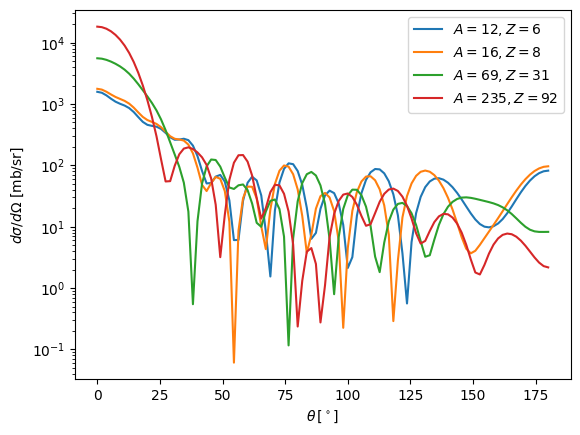

In [ ]:
isotopes = [(12, 6), (16, 8), (69, 31), (235, 92)]
elab = 14.1  # MeV - like from a DT generator

for isotope in isotopes:
    A, Z = isotope
    dxs, _, _, _ = calculate_omp_xs(A, Z, energy_lab)
    plt.plot(
        180 * DEFAULT_THETA_GRID / np.pi,
        dxs,
        label=r"$A = {:d}, Z = {:d}$".format(A, Z),
    )

plt.legend()
plt.yscale("log")
plt.xlabel(r"$\theta \,\left[^\circ\right]$")
plt.ylabel(r"$d\sigma / d \Omega $ [mb/sr]")
plt.show()


Sources used for this includes:
- [Scattering theory: the quantum theory of nonrelativistic collisions, John R. Taylor](https://www.google.com/books/edition/Scattering_Theory/jZEyAwAAQBAJ?hl=en&gbpv=1&dq=%5BBOOK%5D+Scattering+theory:+the+quantum+theory+of+nonrelativistic+collisions+taylor&pg=PP1&printsec=frontcover)
- [Nuclear reactions for astrophysics: principles, calculation and applications of low-energy reactions, Ian J. Thompson and Filomena Nunes](https://www.google.com/books/edition/Nuclear_Reactions_for_Astrophysics/sXH2BufDFyAC?hl=en&gbpv=1&dq=reactions+for+nuclear+astrophysics+ian+thompson&pg=PR5&printsec=frontcover)
- [ Theoretical Physics on the Personal Computer, Erich W. Schmid , Gerhard Spitz , Wolfgang Lösch ](https://link.springer.com/book/10.1007/978-3-642-75471-5)


In [40]:
grid_size = 2000
egrid = np.logspace(-2, 2, grid_size)

isotopes = [(12, 6), (16, 8), (69, 31), (235,92)]

sigt = np.zeros( (grid_size, len(isotopes)))
sigrxn = np.zeros( (grid_size, len(isotopes)))


for i, (A,Z) in enumerate(isotopes):
  # run the solver at each energy
  for j, elab in enumerate(egrid):
    _, t, rxn, el = calculate_omp_xs(A, Z, elab)
    sigt[j,i] = t
    sigrxn[j,i] = rxn

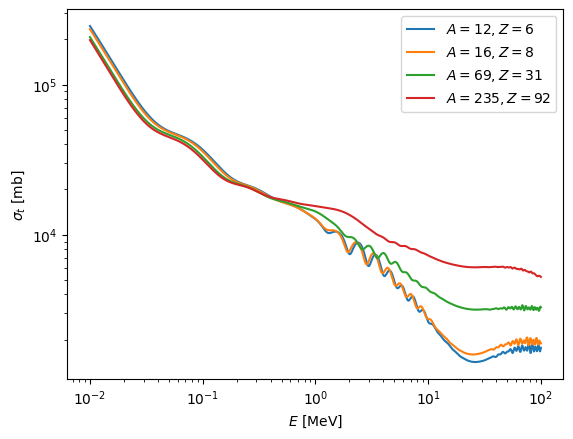

In [45]:
for i, (A,Z) in enumerate(isotopes):
  plt.plot(egrid, sigt[:,i], label=r"$A = {:d}, Z = {:d}$".format(A, Z))
plt.xlabel(r"$E$ [MeV]")
plt.ylabel(r"$\sigma_t$ [mb]")
plt.yscale("log")
plt.xscale("log")

plt.legend()
plt.show()

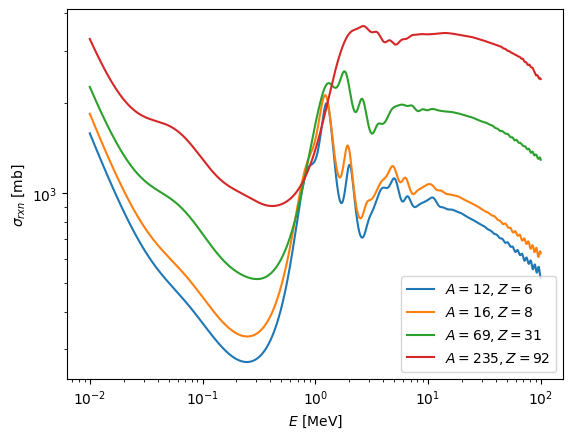

In [46]:
for i, (A,Z) in enumerate(isotopes):
  plt.plot(egrid, sigrxn[:, i], label=r"$A = {:d}, Z = {:d}$".format(A, Z))
plt.xlabel(r"$E$ [MeV]")
plt.ylabel(r"$\sigma_{rxn}$ [mb]")
plt.yscale("log")
plt.xscale("log")

plt.legend()
plt.show()